In [1]:
from plaidml.keras import install_backend
install_backend()

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from code.util import *

In [2]:
N_VOCAB = 4000
N_CLASS = 2
BATCH_SIZE = 512
EPOCHS = 30

In [3]:
x = load("data/largefiles/x_word.pkl")
y = load("data/largefiles/y_onehot.pkl")

In [4]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42)

In [5]:
print(x.shape, y.shape)

(127284, 20) (127284, 2)


In [6]:
model_input = Input(shape=(x.shape[1], ))
H = Embedding(N_VOCAB, 32)(model_input)
H = SpatialDropout1D(0.5)(H)
H = LSTM(32)(H)
model_output = Dense(N_CLASS, activation="softmax")(H)

model = Model(model_input, model_output)
model.summary()

model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 20, 32)            128000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 20, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 136,386
Trainable params: 136,386
Non-trainable params: 0
_________________________________________________________________


In [7]:
es = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(x_test, y_test),
    callbacks=[es]
)

score = model.evaluate(x_test, y_test, verbose=0)

W0819 23:53:44.571313 4577056192 deprecation.py:323] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 89098 samples, validate on 38186 samples
Epoch 1/30
89098/89098 [==============================] - 6s 66us/sample - loss: 0.1967 - accuracy: 0.9257 - val_loss: 0.0884 - val_accuracy: 0.9705
Epoch 2/30
89098/89098 [==============================] - 5s 53us/sample - loss: 0.0810 - accuracy: 0.9736 - val_loss: 0.0889 - val_accuracy: 0.9709
Epoch 3/30
89098/89098 [==============================] - 5s 52us/sample - loss: 0.0728 - accuracy: 0.9768 - val_loss: 0.0774 - val_accuracy: 0.9748
Epoch 4/30
89098/89098 [==============================] - 5s 55us/sample - loss: 0.0682 - accuracy: 0.9783 - val_loss: 0.0757 - val_accuracy: 0.9756
Epoch 5/30
89098/89098 [==============================] - 5s 54us/sample - loss: 0.0655 - accuracy: 0.9790 - val_loss: 0.0739 - val_accuracy: 0.9759
Epoch 6/30
89098/89098 [==============================] - 5s 54us/sample - loss: 0.0631 - accuracy: 0.9800 - val_loss: 0.0736 - val_accuracy: 0.9767
Epoch 7/30
89098/89098 [==============================] 

In [8]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.07307675545073752
Test accuracy: 0.9765097


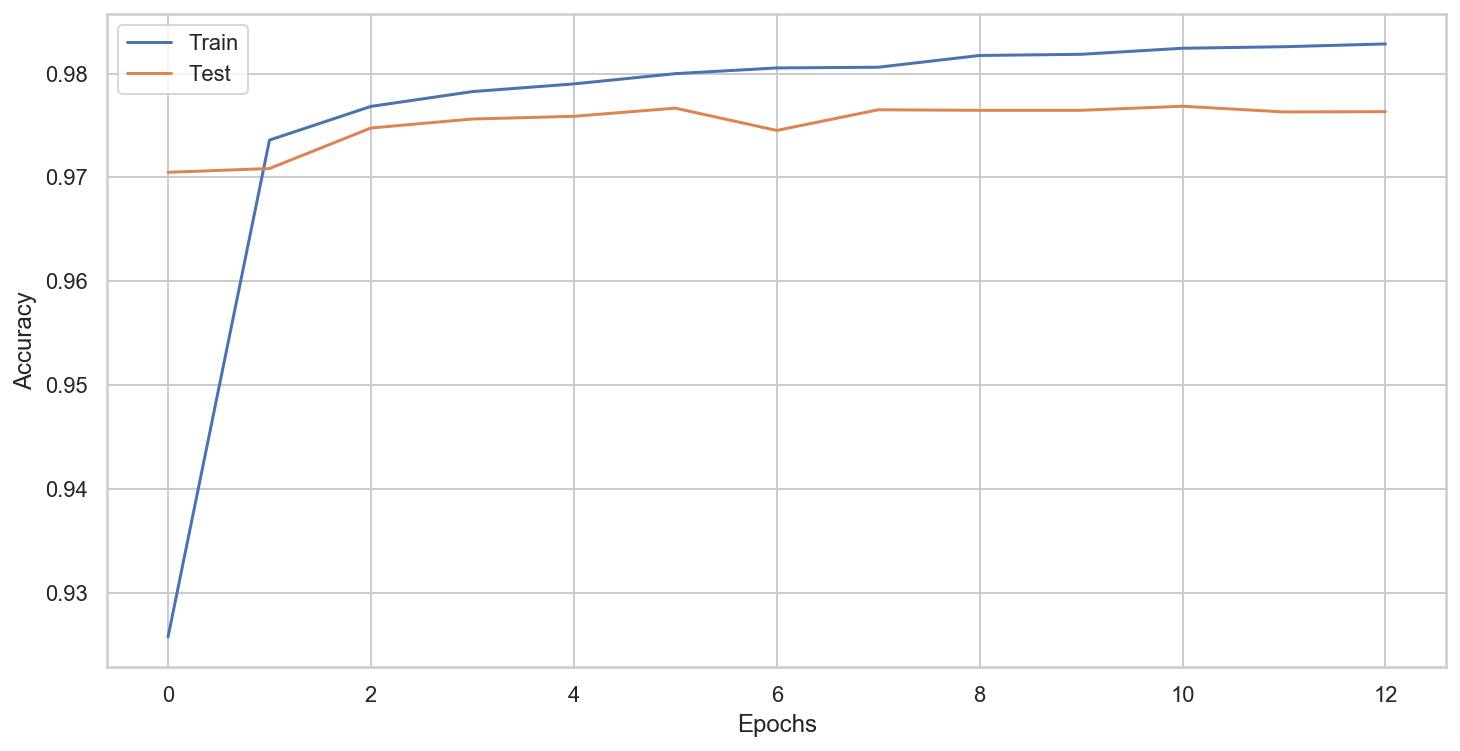

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [10]:
model.save("models/lstm_word.h5")